# Trabalho 2 - Aprendizagem Supervisionada - Classificação
## Francisco Romes da Silva Filho, 409976

### Classificação de partículas gama de alta energia (gamma - signal - ou hadron - background)
O conjunto de dados foi gerado por um programa Monte Carlo, Corsika, descrito em
D. Heck et al., CORSIKA, um código Monte Carlo para simular chuveiros de ar extensos,
Forschungszentrum Karlsruhe FZKA 6019 (1998).
O programa foi executado com parâmetros que permitem observar eventos com energias
abaixo de 50 GeV. O CORSIKA é um programa para simulação detalhada de extensos chuveiros de ar iniciadas por partículas de raios cósmicos de alta energia.

Por razões técnicas, o número de eventos hadron está subestimado.
Nos dados reais, a classe h representa a maioria dos eventos, segundo a fonte do dataset.

Link do dataset: <https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#XGBoost
!pip install xgboost


In [3]:
!pip install pipelinehelper 

In [122]:
!pip install imblearn


## Imports das Bibliotecas

In [123]:
# kNN, SVM, Árvore de Decisão, Random Forest, Gradient Boosting e Redes Neurais
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn import metrics
# kNN
from sklearn.neighbors import KNeighborsClassifier
# SVM.SVC
from sklearn.svm import SVC
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# Redes Neurais
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pipelinehelper import PipelineHelper
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Carregando o dataset

In [5]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/telescope_data.csv')
print("Forma do dataset: ", data.shape[1], " features e ", data.shape[0], " amostras!")

Forma do dataset:  12  features e  19020  amostras!


#### Descrição das Features

1.  fLength:  continuous  -  major axis of ellipse [mm]
2.  fWidth:   continuous  - minor axis of ellipse [mm] 
3.  fSize:    continuous  - 10-log of sum of content of all pixels [in #phot]
4.  fConc:    continuous  - ratio of sum of two highest pixels over fSize  [ratio]
5.  fConc1:   continuous  - ratio of highest pixel over fSize  [ratio]
6.  fAsym:    continuous  - distance from highest pixel to center, projected onto major axis [mm]
7.  fM3Long:  continuous  - 3rd root of third moment along major axis  [mm] 
8.  fM3Trans: continuous  - 3rd root of third moment along minor axis  [mm]
9.  fAlpha:   continuous  - angle of major axis with vector to origin [deg]
10.  fDist:    continuous  - distance from origin to center of ellipse [mm]
11.  class:    g,h  - gamma (signal), hadron (background)

### Visualização inicial e limpeza

In [6]:
data

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...,...
19015,19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [7]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.replace('g', 0, inplace=True)
data.replace('h', 1, inplace=True)

In [8]:
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [9]:
valores_faltantes = data.isna().sum()
valores_faltantes

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

In [10]:
data.duplicated().value_counts()

False    18905
True       115
dtype: int64

In [11]:
data = data.drop_duplicates()

### Análise e Visualização dos Dados

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fLength,18905.0,53.161416,42.259789,4.2835,24.3597,37.1295,69.9754,334.1770
fWidth,18905.0,22.145872,18.300664,0.0000,11.8742,17.1438,24.7124,256.3820
fSize,18905.0,2.824643,0.472377,1.9413,2.4771,2.7400,3.1011,5.3233
fConc,18905.0,0.380247,0.182709,0.0131,0.2358,0.3540,0.5035,0.8930
fConc1,18905.0,0.214560,0.110384,0.0003,0.1285,0.1964,0.2850,0.6752
fAsym,18905.0,-4.177867,59.010059,-457.9161,-20.4791,4.0629,24.1335,575.2407
fM3Long,18905.0,10.618826,50.900687,-331.7800,-12.7693,15.3380,35.8694,238.3210
fM3Trans,18905.0,0.259364,20.775268,-205.8947,-10.8358,0.7500,10.9489,179.8510
fAlpha,18905.0,27.551644,26.083055,0.0000,5.5164,17.5330,45.7040,90.0000
fDist,18905.0,193.712554,74.685712,1.2826,142.2690,191.8320,240.4090,495.5610


In [13]:
data.corr()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
fLength,1.000000,0.770007,0.701911,-0.630202,-0.597479,-0.365627,-0.118704,0.015451,-0.010606,0.417785,0.308146
fWidth,0.770007,1.000000,0.716441,-0.608862,-0.580373,-0.263574,-0.174107,0.040436,0.064629,0.334571,0.265948
fSize,0.701911,0.716441,1.000000,-0.850951,-0.809135,-0.156630,0.098994,0.014858,-0.188410,0.435801,0.117792
fConc,-0.630202,-0.608862,-0.850951,1.000000,0.976455,0.109459,-0.124819,-0.011227,0.236619,-0.327334,-0.025442
fConc1,-0.597479,-0.580373,-0.809135,0.976455,1.000000,0.097535,-0.121791,-0.010857,0.230969,-0.303711,-0.006053
fAsym,-0.365627,-0.263574,-0.156630,0.109459,0.097535,1.000000,0.273706,0.002658,-0.055229,-0.206265,-0.172109
fM3Long,-0.118704,-0.174107,0.098994,-0.124819,-0.121791,0.273706,1.000000,-0.015258,-0.186505,0.039935,-0.193503
fM3Trans,0.015451,0.040436,0.014858,-0.011227,-0.010857,0.002658,-0.015258,1.000000,0.004810,0.011472,0.004516
fAlpha,-0.010606,0.064629,-0.188410,0.236619,0.230969,-0.055229,-0.186505,0.004810,1.000000,-0.222757,0.460421
fDist,0.417785,0.334571,0.435801,-0.327334,-0.303711,-0.206265,0.039935,0.011472,-0.222757,1.000000,0.063877


In [14]:
data.corr()['class']

fLength     0.308146
fWidth      0.265948
fSize       0.117792
fConc      -0.025442
fConc1     -0.006053
fAsym      -0.172109
fM3Long    -0.193503
fM3Trans    0.004516
fAlpha      0.460421
fDist       0.063877
class       1.000000
Name: class, dtype: float64

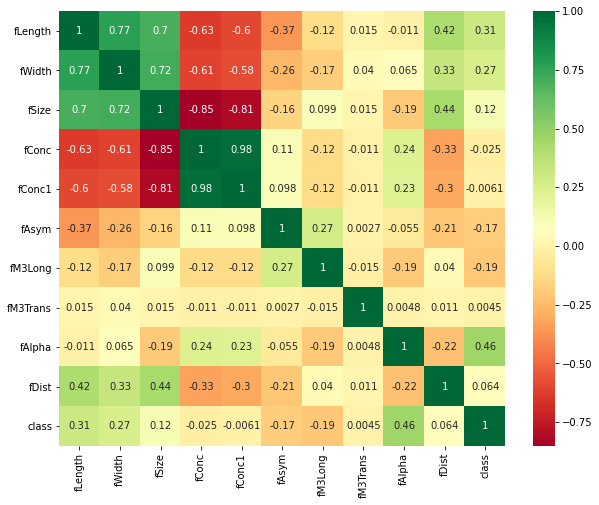

In [15]:
sns.heatmap(data[data.columns[:]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [16]:
# A maior partes dos rótulos é Gamma
data['class'].value_counts()

0    12332
1     6573
Name: class, dtype: int64

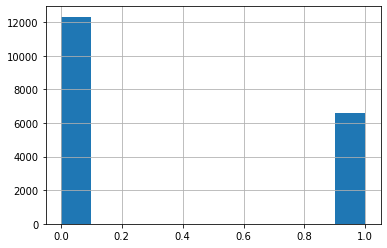

In [17]:
data['class'].hist()

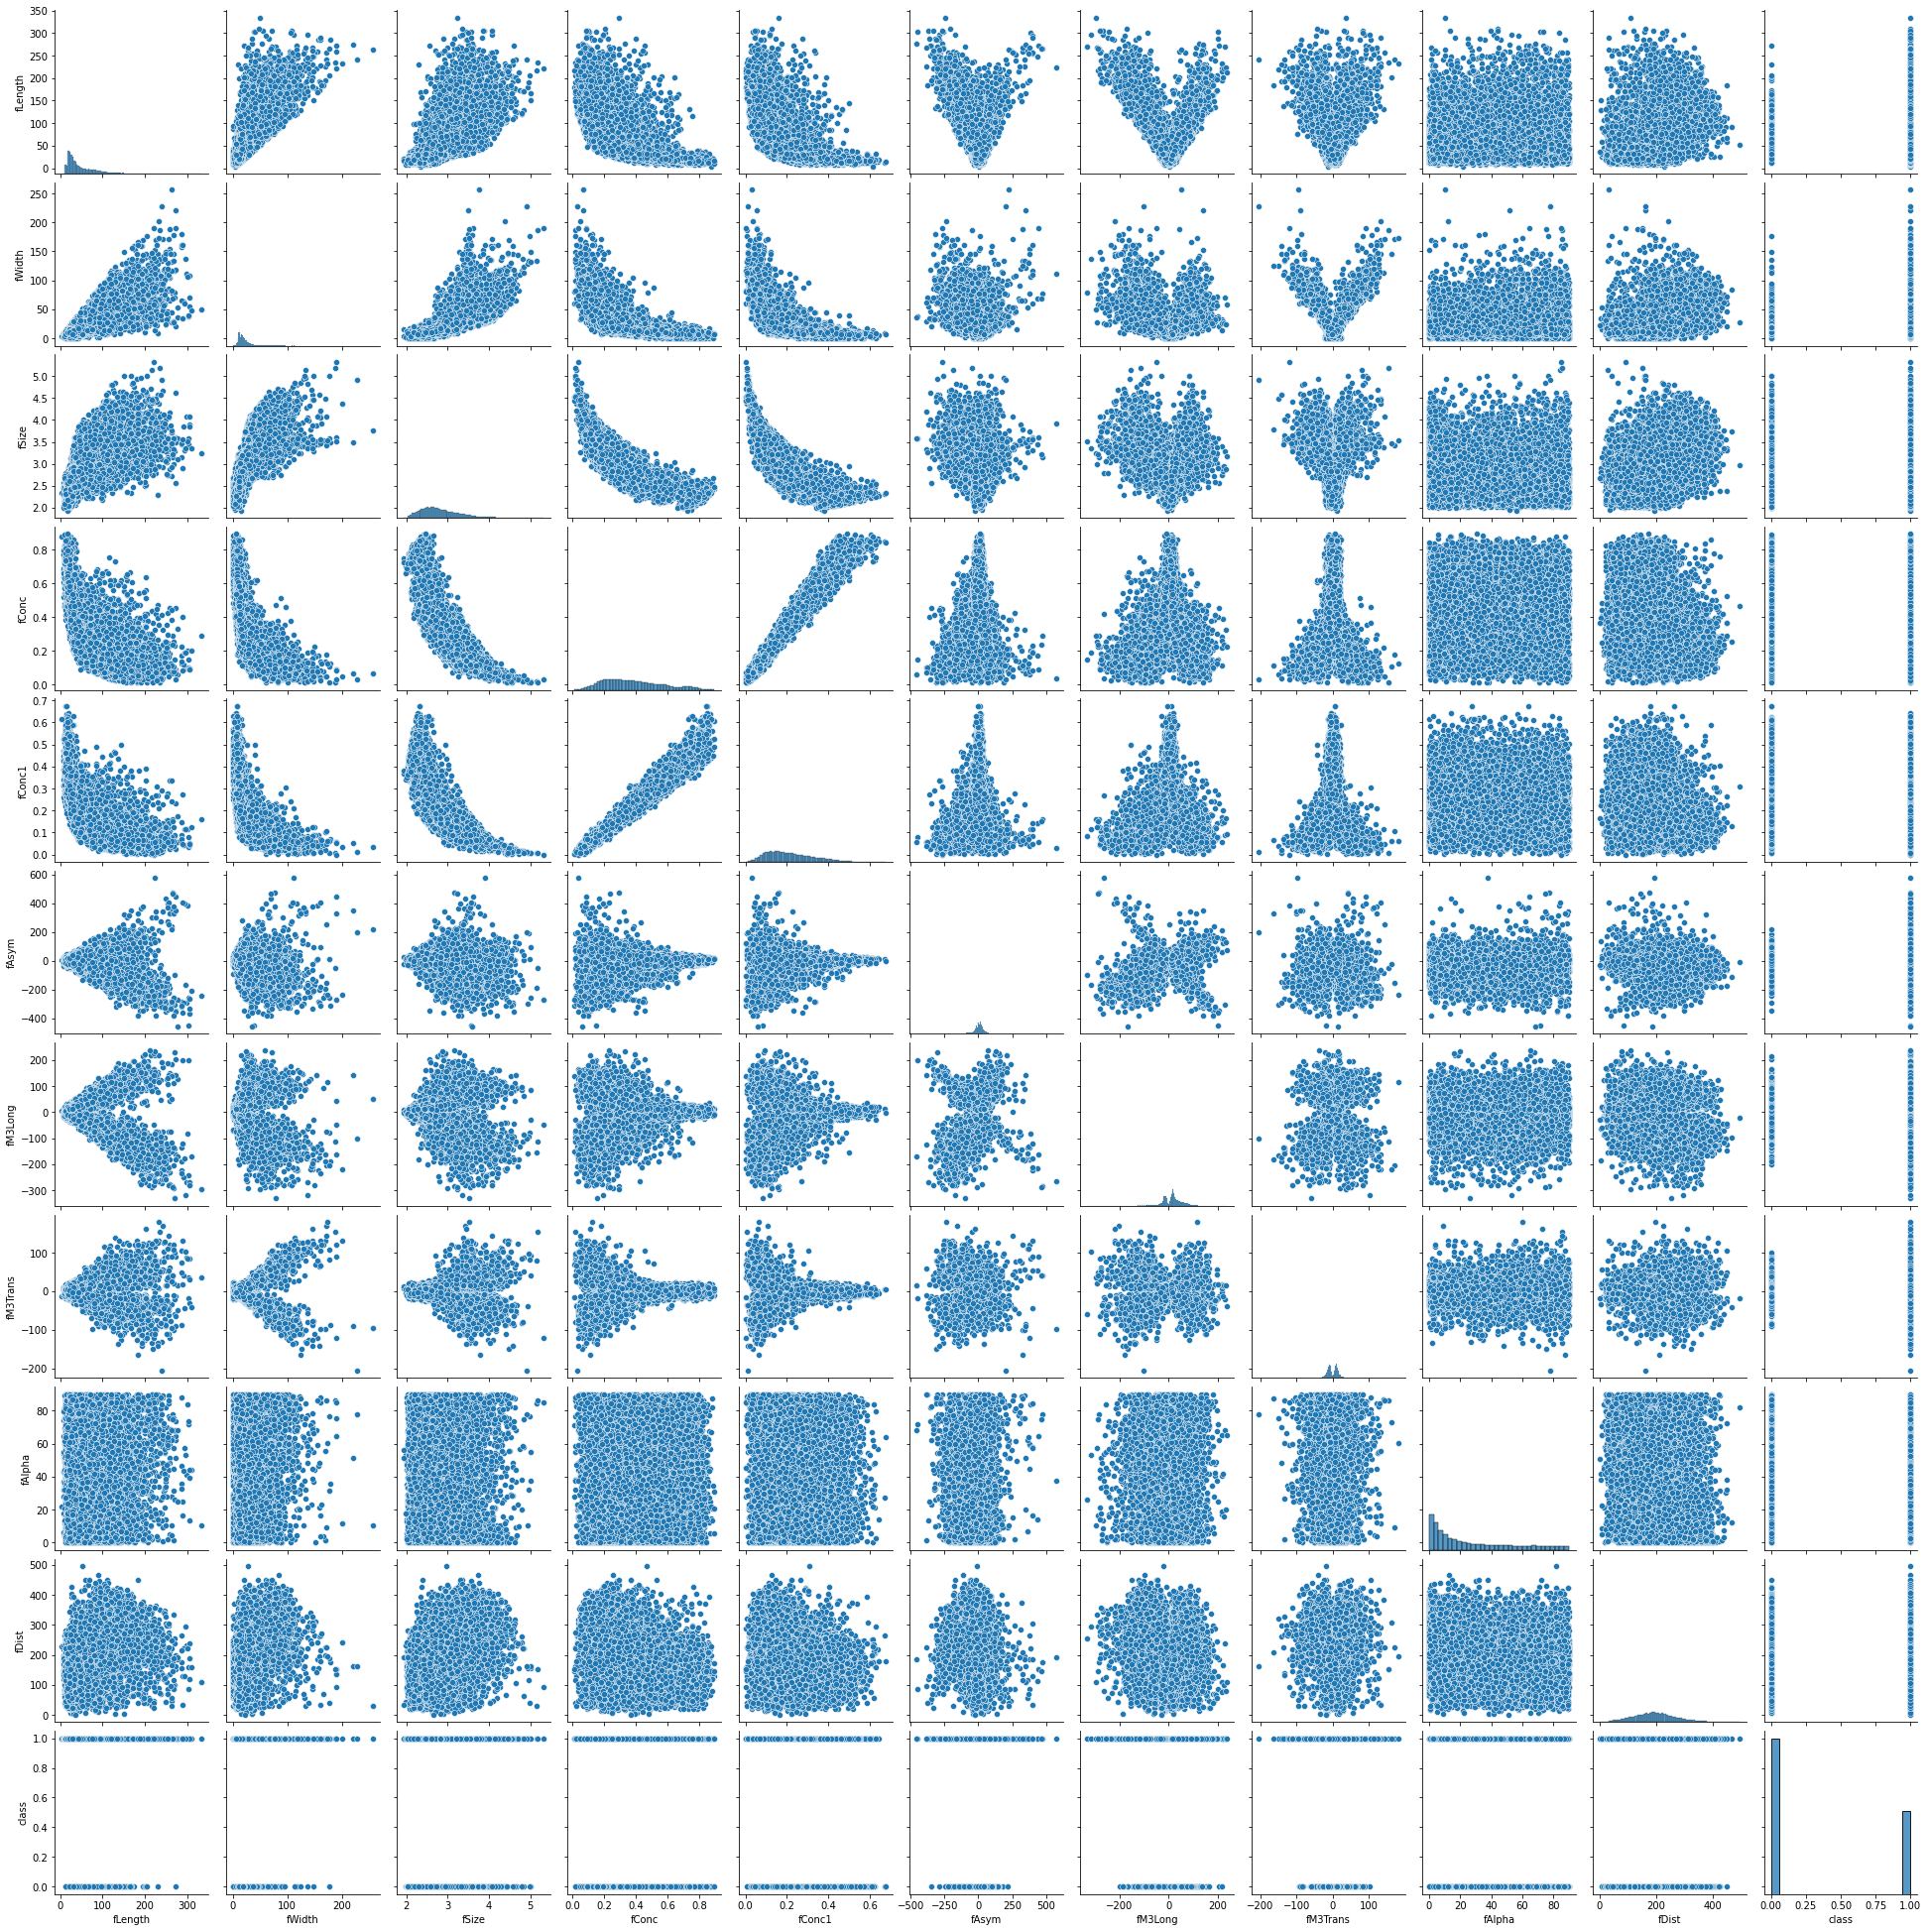

In [18]:
df = data.copy()
sns.pairplot(data=df)

## Separação do dataset em treino e teste

In [127]:
X = data.drop(['class'], axis=1)
y = data['class']

##### Usando Oversampling para equilibrar a quantidade de amostras para cada classe

In [205]:
#SMOTE
smote = SMOTE(random_state = 0)
X, y = smote.fit_resample(X, y)

In [201]:
print("Amostras com 0: ", np.bincount(y)[0])
print("Amostras com 1: ", np.bincount(y)[1])

Amostras com 0:  12332
Amostras com 1:  12332


In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [209]:
# targets no treino
print("Amostras com 0: ", np.bincount(y_train)[0])
print("Amostras com 1: ", np.bincount(y_train)[1])

Amostras com 0:  8632
Amostras com 1:  8632


In [208]:
# targets no teste
print("Amostras com 0: ", np.bincount(y_test)[0])
print("Amostras com 1: ", np.bincount(y_test)[1])

Amostras com 0:  3700
Amostras com 1:  3700


## Modelos

In [130]:
columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
index = ['kNN', 'SVM', 'DT', 'RF', 'XGB', 'MLP']

In [131]:
modelos = pd.DataFrame(columns=columns, index=index)
modelos

,Accuracy,Precision,Recall,F1 Score
kNN,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
DT,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN
XGB,NaN,NaN,NaN,NaN
MLP,NaN,NaN,NaN,NaN


### kNN

In [132]:
pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MinMaxScaler()),
        ])),
    ('classifier', PipelineHelper([
        ('knn', KNeighborsClassifier()),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],  
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
        'knn__n_neighbors': [1, 3, 10, 15, 20, 30],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
        'knn__n_jobs':[-1],
    })
}

In [133]:
knn = GridSearchCV(pipe, params, scoring='f1', verbose=1, n_jobs=-1)

In [134]:
knn.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.9min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        PipelineHelper(available_models={'max': MinMaxScaler(copy=True,
                                                                                             feature_range=(0,
                                                                                                            1)),
                                                                         'std': StandardScaler(copy=True,
                                                                                               with_mean=True,
                                                                                               with_std=True)},
                                                       optional=False,
                                                       selected_model=None)),
                                       ('classifier',
      

#### Melhor configuração

In [135]:
print("Melhores valores para os parâmetros do kNN:\n")
print(knn.best_params_)
print("F1 score no treinamento:\n")
print(knn.best_score_)

Melhores valores para os parâmetros do kNN:

{'classifier__selected_model': ('knn', {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 1, 'weights': 'uniform'}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}
F1 score no treinamento:

0.8634790839796876


#### Execução com o conjunto de teste

In [136]:
knn_pred = knn.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [137]:
f1_score(y_test, knn_pred)

0.8710754843019373

In [138]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3700
           1       0.86      0.88      0.87      3700

    accuracy                           0.87      7400
   macro avg       0.87      0.87      0.87      7400
weighted avg       0.87      0.87      0.87      7400



In [139]:
modelos.loc['kNN', 'Accuracy'] = accuracy_score(y_test, knn_pred)
modelos.loc['kNN', 'Precision'] = precision_score(y_test, knn_pred)
modelos.loc['kNN', 'Recall'] = recall_score(y_test, knn_pred)
modelos.loc['kNN', 'F1 Score'] = f1_score(y_test, knn_pred)

### SVM.SVC

In [140]:
pipe = Pipeline([
    ('scaler', PipelineHelper([
        ('std', StandardScaler()),
        ('max', MinMaxScaler()),
    ])),
    ('classifier', PipelineHelper([
        ('svc', SVC()),
    ])),
])

params = {
    'scaler__selected_model': pipe.named_steps['scaler'].generate({
        'std__with_mean': [True, False],
        'std__with_std': [True, False],
        'max__copy': [True],  
    }),
    'classifier__selected_model': pipe.named_steps['classifier'].generate({
      'svc__C': [1, 10, 100],
      'svc__gamma':[1, 0.1, 0.01],
      
      })
}

In [141]:
svc = GridSearchCV(pipe, params, scoring='f1', verbose=1, n_jobs=-1)

In [142]:
svc.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed: 49.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        PipelineHelper(available_models={'max': MinMaxScaler(copy=True,
                                                                                             feature_range=(0,
                                                                                                            1)),
                                                                         'std': StandardScaler(copy=True,
                                                                                               with_mean=True,
                                                                                               with_std=True)},
                                                       optional=False,
                                                       selected_model=None)),
                                       ('classifier',
      

#### Melhor configuração

In [143]:
print("Melhor do configuração do SVC:\n")
print(svc.best_params_)
print("F1 score no treinamento:\n")
print(svc.best_score_)

Melhor do configuração do SVC:

{'classifier__selected_model': ('svc', {'C': 10, 'gamma': 1}), 'scaler__selected_model': ('std', {'with_mean': True, 'with_std': True})}
F1 score no treinamento:

0.8656737224522564


#### Execução com conjunto de teste

In [144]:
svc_pred = svc.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [145]:
f1_score(y_test, svc_pred)

0.87194791101465

In [146]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      3700
           1       0.88      0.87      0.87      3700

    accuracy                           0.87      7400
   macro avg       0.87      0.87      0.87      7400
weighted avg       0.87      0.87      0.87      7400



In [147]:
modelos.loc['SVM', 'Accuracy'] = accuracy_score(y_test, svc_pred)
modelos.loc['SVM', 'Precision'] = precision_score(y_test, svc_pred)
modelos.loc['SVM', 'Recall'] = recall_score(y_test, svc_pred)
modelos.loc['SVM', 'F1 Score'] = f1_score(y_test, svc_pred)

### Decision Tree

In [148]:
dt_model = DecisionTreeClassifier()
params = {
          'criterion': ['entropy', 'gini'], 
          'max_depth': np.arange(3, 15),
          }

In [149]:
dt = GridSearchCV(dt_model, params, scoring='f1', verbose=1, n_jobs=-1)

In [150]:
dt.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   16.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                  

#### Melhor configuração

In [151]:
print("Melhor configuração do Decision Tree:\n")
print(dt.best_params_)
print("\nF1 Score no treinamento:")
print(dt.best_score_)

Melhor configuração do Decision Tree:

{'criterion': 'entropy', 'max_depth': 11}

F1 Score no treinamento:
0.8267948026170281


#### Execução com o conjunto de teste

In [152]:
dt_pred = dt.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [153]:
f1_score(y_test, dt_pred)

0.8357372916958409

In [154]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3700
           1       0.87      0.81      0.84      3700

    accuracy                           0.84      7400
   macro avg       0.84      0.84      0.84      7400
weighted avg       0.84      0.84      0.84      7400



In [155]:
modelos.loc['DT', 'Accuracy'] = accuracy_score(y_test, dt_pred)
modelos.loc['DT', 'Precision'] = precision_score(y_test, dt_pred)
modelos.loc['DT', 'Recall'] = recall_score(y_test, dt_pred)
modelos.loc['DT', 'F1 Score'] = f1_score(y_test, dt_pred)

### Random Forest

In [156]:
rf_model =  RandomForestClassifier()

params = {
        'n_estimators': [100, 200, 300],
        'max_depth': np.arange(3, 15)
        }

In [157]:
rf = GridSearchCV(rf_model, params, scoring='f1', verbose=1, n_jobs=-1)

In [158]:
rf.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 12.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

#### Melhor configuração

In [159]:
print("Melhor configuração do Random Forest:\n")
print(rf.best_params_)
print("\nF1 Score no treinamento:")
print(rf.best_score_)

Melhor configuração do Random Forest:

{'max_depth': 14, 'n_estimators': 200}

F1 Score no treinamento:
0.8690136399800451


#### Execução com o conjunto de teste 

In [160]:
rf_pred = rf.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [161]:
f1_score(y_test, rf_pred)

0.8743900738881918

In [162]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3700
           1       0.90      0.85      0.87      3700

    accuracy                           0.88      7400
   macro avg       0.88      0.88      0.88      7400
weighted avg       0.88      0.88      0.88      7400



In [163]:
modelos.loc['RF', 'Accuracy'] = accuracy_score(y_test, rf_pred)
modelos.loc['RF', 'Precision'] = precision_score(y_test, rf_pred)
modelos.loc['RF', 'Recall'] = recall_score(y_test, rf_pred)
modelos.loc['RF', 'F1 Score'] = f1_score(y_test, rf_pred)

### Gradient Boosting

In [164]:
xgb = XGBClassifier(objective="binary:logistic")
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.1, 0.01, 0.05],
}

In [165]:
xgb = GridSearchCV(xgb, param_grid, n_jobs=-1, cv=5, scoring="f1")


In [166]:
xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 7],
                         'n_estimators': [100, 200, 300]},
       

#### Melhor configuração

In [167]:
print("Melhor configuração do XGBoost:\n")
print(xgb.best_params_)
print("\nF1 Score no treinamento:")
print(xgb.best_score_)

Melhor configuração do XGBoost:

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}

F1 Score no treinamento:
0.878570940246264


#### Execução com o conjunto de teste

In [168]:
xgb_pred = xgb.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [169]:
f1_score(y_test, xgb_pred)

0.8880896389542121

In [170]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3700
           1       0.91      0.87      0.89      3700

    accuracy                           0.89      7400
   macro avg       0.89      0.89      0.89      7400
weighted avg       0.89      0.89      0.89      7400



In [171]:
modelos.loc['XGB', 'Accuracy'] = accuracy_score(y_test, xgb_pred)
modelos.loc['XGB', 'Precision'] = precision_score(y_test, xgb_pred)
modelos.loc['XGB', 'Recall'] = recall_score(y_test, xgb_pred)
modelos.loc['XGB', 'F1 Score'] = f1_score(y_test, xgb_pred)

### Redes Neurais - MLP

In [172]:
mlp_model = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
}

In [173]:
mlp = GridSearchCV(mlp_model, param_grid, n_jobs=-1, cv=5, scoring="f1")


In [174]:
mlp.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

#### Melhor configuração

In [175]:
print("Melhor configuração do MLP:\n")
print(mlp.best_params_)
print("\nF1 Score no treinamento:")
print(mlp.best_score_)

Melhor configuração do MLP:

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'solver': 'adam'}

F1 Score no treinamento:
0.7965290279492477


#### Execução com o conjunto de teste

In [176]:
mlp_pred = mlp.predict(X_test)

#### Avaliação com F1 Score e com classification_report

In [177]:
f1_score(y_test, mlp_pred, )

0.8125587011941501

In [178]:
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3700
           1       0.81      0.82      0.81      3700

    accuracy                           0.81      7400
   macro avg       0.81      0.81      0.81      7400
weighted avg       0.81      0.81      0.81      7400



In [179]:
modelos.loc['MLP', 'Accuracy'] = accuracy_score(y_test, mlp_pred)
modelos.loc['MLP', 'Precision'] = precision_score(y_test, mlp_pred)
modelos.loc['MLP', 'Recall'] = recall_score(y_test, mlp_pred)
modelos.loc['MLP', 'F1 Score'] = f1_score(y_test, mlp_pred)

## Discussão dos Resultados

A simples acurácia da classificação não é significativa para esses dados, uma vez que classificar um evento de h (background) como g (signal) é pior do que classificar um evento de g (signal) como h (background). Vamos utilizar uma Curva ROC para evidenciar o melhor modelo preditivo. 

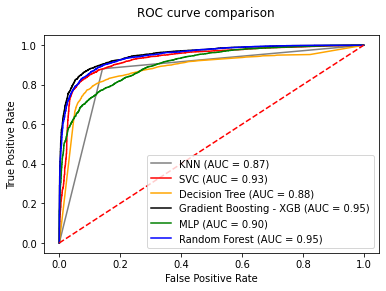

In [217]:
knn_disp = metrics.plot_roc_curve(knn, X_test, y_test, name ='KNN', color='gray')  
svc_disp = metrics.plot_roc_curve(svc, X_test, y_test, name ='SVC', ax=knn_disp.ax_, color='r')  
dt_disp = metrics.plot_roc_curve(dt, X_test, y_test, name ='Decision Tree', ax=svc_disp.ax_, color='orange')
xgb_disp = metrics.plot_roc_curve(xgb, X_test, y_test, ax=dt_disp.ax_, name ='Gradient Boosting - XGB', color='black')
mlp_disp = metrics.plot_roc_curve(mlp, X_test, y_test, ax=xgb_disp.ax_, name ='MLP', color='g')
rf_disp = metrics.plot_roc_curve(rf, X_test, y_test, ax=mlp_disp.ax_, name ='Random Forest', color='blue')
rf_disp.figure_.suptitle("ROC curve comparison")
plt.plot([0, 1], [0, 1],'r--')
plt.show()

#### Ordem dos melhores modelos por Acurácia

In [181]:
modelos = modelos.sort_values(by=['Accuracy'], ascending=0)
modelos

,Accuracy,Precision,Recall,F1 Score
XGB,0.890676,0.909606,0.867568,0.88809
RF,0.878243,0.902966,0.847568,0.87439
SVM,0.872432,0.875272,0.868649,0.871948
kNN,0.869595,0.861295,0.881081,0.871075
DT,0.841486,0.86719,0.806486,0.835737
MLP,0.811216,0.806821,0.818378,0.812559


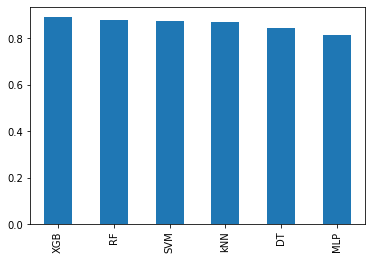

In [182]:
modelos['Accuracy'].plot(kind='bar')

### Conclusão: dado a avaliação de todas as métricas e observando a Curva ROC, os modelos XGBoost (Gradient Boosting) e Random Forest foram os melhores modelos. 

#### Comparando com outros trabalhos

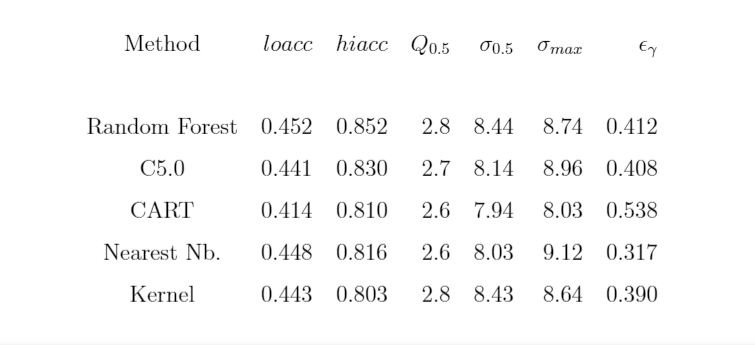

Tabela dos resultados apresentados em "Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope". 

Bock, R.K., Chilingarian, A., Gaug, M., Hakl, F., Hengstebeck, T., Jirina, M., Klaschka, J., Kotrc, E., Savicky, P., Towers, S., Vaicilius, A., Wittek W. (2004). Methods for multidimensional event classification: a case study using images from a Cherenkov gamma-ray telescope. Nucl.Instr.Meth. A, 516, pp. 511-528.